In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D  # For custom legend entries
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.gridspec as gridspec
import hydroeval as he
import re

from function import preprocessUtils as putils
from function import masks
from function import verifications
from function import funs as f
from function import conf
from function import loadbias
from function import quikplot as qp
from function import dataLoad


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

global dim_order, region_name, test_year, leads_
dim_order = conf.dim_order

test_year = 2019
leads_ = [6,13,20,27]

dir = '/glade/work/klesinger/FD_RZSM_deep_learning'
assert test_year == 2019, 'This is only the script for when the testing years are 2018-2019. Test year must = 2019.'


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## This script only works if there is a single experiment done for china and australia
### We are doing EX29 only
### For both ECMWF and GEFSv12

In [2]:
region_name = 'china' #['australia','china']
obs_source = 'ERA5' #['GLEAM','ERA5']

if obs_source == 'ERA5':
    soil_dir = conf.era_data
elif obs_source == 'GLEAM':
    soil_dir = conf.gleam_data

In [3]:
mask, mask_anom = masks.load_mask_vals(region_name)


In [4]:
global custom_names
'''This is for the final plot for ACC and CRPS'''
custom_names = {
    'GEFSv12': 'GEFSv12','GEFSv12-BC': 'GEFSv12-BC', 'DL-DM_GEFSv12': 'DL-DM-GEFSv12','DL-DM_ECMWF': 'DL-DM-ECMWF',
    'ECMWF':'ECMWF', 'ECMWF-BC':'ECMWF-BC',
}

        
def return_name(name):
    if 'XGBOOST' in name:
        name_out = 'ML_NWP_OBS'
    else:
        name_out = name
    custom_names = {name: name_out}

    return(custom_names)

In [5]:
'''Testing and validation dates only for the year 2019'''

test_start = '2018-01-01'
test_end = '2019-12-31'
val_start = '2016-01-01'
val_end = '2017-12-31'
train_start  = '2000-01-01'


'''Test subsets of obs, ecmwf raw, gefsv12 raw '''
global obs_anomaly_SubX_format, baseline_gefs, baseline_ecmwf, var_OUT, template_testing_only
obs_anomaly_SubX_format, baseline_gefs, baseline_ecmwf, var_OUT, template_testing_only = verifications.open_obs_and_baseline_files_multiple_leads(region_name, leads_, test_start, test_end, mask_anom, soil_dir)

init_dates, dt_dates, only_testing_dates = dataLoad.return_init_and_testing_dates(region_name,test_start,test_end)


Loading soil data all the baseline files for observations, GEFSv12, and ECMWF for region china
Loading /glade/derecho/scratch/klesinger/FD_RZSM_deep_learning/Data/reanalysis/ERA5 observations
Loading GEFS data
Loading ECMWF data


In [6]:
global obs_original,obs_raw
obs_original,obs_raw = dataLoad.load_rzsm_observations(soil_dir, region_name)
obs_original["time"] = obs_original["time"].dt.floor("D")
obs_raw["time"] = obs_raw["time"].dt.floor("D")

# Lineplot ACC and CRPS all experiments

In [7]:

def add_lineplot_to_dataframe(df,fcst_vals,name_of_fcst, metric,week, mean_or_median):
    # df = pd.DataFrame()
    def return_color(name_of_fcst):
        black = ['EX0','EX13'] # bias-corrected DL
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] #Observation driven
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28','EX29'] #Hybrid

        black2 = ['DM-BC_DL']
        red2 = ['DL']
        blue2 = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'GEFSv12-BC'

        orange = 'ECMWF-BC'

        yellow = 'EMOS'

        if (name_of_fcst in black) or (name_of_fcst in black2):
            color = 'black'
        elif (name_of_fcst in red) or (name_of_fcst in red2):
            color = 'red'
        elif (name_of_fcst in blue) or (name_of_fcst in blue2):
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
        elif orange in name_of_fcst:
            color='orange'
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            if mean_or_median == 'mean':
                try:
                    data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
                except KeyError:
                    data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
            if mean_or_median == 'median':
                try:
                    data = fcst_vals.sel(lead=lead).median()[putils.xarray_varname(fcst_vals)].values
                except AttributeError:
                    data = np.nanmedian(fcst_vals[idx,:,:])
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    return(df)


'''Only the single value for all the experiments'''

def add_lineplot_to_dataframe_average(df,fcst_vals,name_of_fcst, metric,week, mean_or_median):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['DM-BC_DL']
        red = ['DL']
        blue = ['DL-DM_GEFSv12']
        purple = ['DL-DM_ECMWF']
        
        green = ['ECMWF','GEFSv12']
        

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif name_of_fcst in purple:
            color = 'purple'
        elif name_of_fcst in yellow:
            color = 'yellow'
            
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            if mean_or_median == 'mean':
                data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            elif mean_or_median == 'median':
                try:
                    data = fcst_vals.sel(lead=lead).median()[putils.xarray_varname(fcst_vals)].values
                except AttributeError:
                    data = np.nanmedian(fcst_vals[idx,:,:])
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
            
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    
    return(df)

def add_lineplot_to_dataframe_average_by_week(df,fcst_vals,name_of_fcst, metric,week, mean_or_median, lead, idLead):
    # df = pd.DataFrame()

    # df = df_crps_djf
    # fcst_vals = seasonal_crps[season]
    # name_of_fcst = name
    # metric = 'CRPSS'
    # week = 10
    # mean_or_median = 'median'
    # lead=day_num
    # idLead = idLead
    
    def return_color(name_of_fcst):
        black = ['DM-BC_DL']
        red = ['DL']
        blue = ['DL-DM_GEFSv12']
        purple = ['DL-DM_ECMWF']
        
        green = ['ECMWF','GEFSv12']


        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif name_of_fcst in purple:
            color = 'purple'
        elif name_of_fcst in yellow:
            color = 'yellow'
            
        return(color)

    if week==10:
        if mean_or_median == 'mean':
            data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.sel(lead=lead).median()
        dict_ = {'Forecast':[name_of_fcst], 'Week':[idLead+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        try:
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
        except TypeError:
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idLead+1], f'{metric}': [data[putils.xarray_varname(data)].values], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
            
    else:
        if mean_or_median == 'mean':
            data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        elif mean_or_median == 'median':
            data = fcst_vals.median()[putils.xarray_varname(fcst_vals)].values
            
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    
    return(df)

In [8]:
def common_UNET_experiments(correct_experiments, obs_source):
    only_RZSM = [j for j in correct_experiments if 'RZSM' in j] 
    only_ensemble= [j for j in only_RZSM if 'final' not in j]
    only_ensemble = [j for j in only_ensemble if 'Residual' not in j]
    only_2019 = [j for j in only_ensemble if '2012' not in j]
    if obs_source == 'GLEAM':
        only_2019 = [j for j in only_ensemble if 'ERA5' not in j]
    elif obs_source == 'ERA5':
        only_2019 = [j for j in only_ensemble if 'ERA5' in j]
    return(only_2019)

def common_UNET_no_regular_experiments(correct_experiments):
    only_RZSM = [j for j in correct_experiments if 'RZSM' in j] 
    only_ensemble= [j for j in only_RZSM if 'final' not in j]
    only_ensemble = [j for j in only_ensemble if 'Residual' not in j]
    only_ensemble = [j for j in only_ensemble if 'regular' not in j]
    only_2019 = [j for j in only_ensemble if '2012' not in j]
    return(only_2019)

In [9]:


def filter_files_by_ex_GEFS(file_list, color_list, week_,obs_source):
    filtered_files = []
    
    for file in file_list:
        if obs_source== 'GLEAM':
            match = re.search(rf'Wk{week_}_testing_EX(\d+)_regular_RZSM', file)
        elif obs_source == 'ERA5':
            match = re.search(rf'Wk{week_}_testing_EX(\d+)_regular_ERA5_RZSM', file)
        if match:
            ex_value = f"EX{match.group(1)}"
            if ex_value in color_list:
                filtered_files.append(file)
    
    return filtered_files

def filter_files_by_ex_ECMWF(file_list, color_list, week_,obs_source):
    filtered_files = []
    
    for file in file_list:
        if obs_source =='GLEAM':
            match = re.search(rf'Wk{week_}_testing_EX(\d+)_ECMWF_regular_RZSM', file)
        elif obs_source == 'ERA5':
            match = re.search(rf'Wk{week_}_testing_EX(\d+)_ECMWF_regular_ERA5_RZSM', file)
        if match:
            ex_value = f"EX{match.group(1)}"
            if ex_value in color_list:
                filtered_files.append(file)
    
    return filtered_files

def return_file_list_by_category(region_name, week_,obs_source):
    black = ['EX0','EX13']
    red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
    blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
           'EX18','EX19','EX20','EX21','EX27','EX28','EX29']
    
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data
    #First find the correct experiments
    bias_correction_black_G = filter_files_by_ex_GEFS(unet_files, black, week_,obs_source)
    hybrid_blue_G = filter_files_by_ex_GEFS(unet_files, blue, week_,obs_source)
    obs_red_G = filter_files_by_ex_GEFS(unet_files, red, week_,obs_source)

    bias_correction_black_E = filter_files_by_ex_ECMWF(unet_files, black, week_,obs_source)
    hybrid_blue_E = filter_files_by_ex_ECMWF(unet_files, blue, week_,obs_source)
    obs_red_E = filter_files_by_ex_ECMWF(unet_files, red, week_,obs_source)
    
    return bias_correction_black_G, hybrid_blue_G, obs_red_G, bias_correction_black_E, hybrid_blue_E, obs_red_E


def create_empty_array(ecmwf_acc, day_num):
    u_acc = ecmwf_acc.sel(lead=day_num).copy(deep=True)
    u_crps = ecmwf_acc.sel(lead=day_num).copy(deep=True)
    u_acc[putils.xarray_varname(u_acc)][:,:] = 0
    u_crps[putils.xarray_varname(u_crps)][:,:] = 0
    return u_acc, u_crps

In [10]:
def calculate_ACC_raw_forecast_all_seasons(obs_original, gefs, ecmwf):

    df_acc_full = pd.DataFrame()
    df_crps_full = pd.DataFrame()
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    df_acc_full = add_lineplot_to_dataframe(df_acc_full,gefs_acc,'GEFSv12', 'ACC',10, 'mean') #Just keep the name the same for later

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    df_acc_full = add_lineplot_to_dataframe(df_acc_full,gefs_acc,'ECMWF', 'ACC',10, 'mean') #Just keep the name the same for later

    gefs_crpss = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    df_crps_full = add_lineplot_to_dataframe(df_crps_full,gefs_crpss,'GEFSv12', 'CRPSS',10, 'median') #Just keep the name the same for later
    
    ecmwf_crpss = verifications.create_climpred_CRPSS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    df_crps_full = add_lineplot_to_dataframe(df_crps_full,gefs_crpss,'ECMWF', 'CRPSS',10, 'median') #Just keep the name the same for later



    
    return df_acc_full, df_crps_full

In [11]:


def calculate_ACC_raw_forecast_split_seasons(obs_original, gefs, ecmwf):
    df_acc_djf = pd.DataFrame()
    df_acc_mam = pd.DataFrame()
    df_acc_jja = pd.DataFrame()
    df_acc_son = pd.DataFrame()
    
    df_crps_djf = pd.DataFrame()
    df_crps_mam = pd.DataFrame()
    df_crps_jja = pd.DataFrame()
    df_crps_son = pd.DataFrame()

    

    seasons = {
        "DJF": [12, 1, 2],  # Winter
        "MAM": [3, 4, 5],   # Spring
        "JJA": [6, 7, 8],   # Summer
        "SON": [9, 10, 11]  # Fall
    }

    for season, months in seasons.items():
        # break
        # Filter datasets for the current season
        obs_season = obs_original.sel(time=obs_original['time'].dt.month.isin(months))
        gefs_season = gefs.sel(S=gefs['S'].dt.month.isin(months))
        ecmwf_season = ecmwf.sel(S=ecmwf['S'].dt.month.isin(months))

        # Compute ACC and CRPSS for the season
        gefs_acc = verifications.create_climpred_ACC(
            verifications.rename_subx_for_climpred(gefs_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )
        ecmwf_acc = verifications.create_climpred_ACC(
            verifications.rename_subx_for_climpred(ecmwf_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )

        gefs_crps = verifications.create_climpred_CRPSS(
            verifications.rename_subx_for_climpred(gefs_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )
        ecmwf_crps = verifications.create_climpred_CRPSS(
            verifications.rename_subx_for_climpred(ecmwf_season), 
            verifications.rename_obs_for_climpred(obs_season)
        )


        if season == 'DJF':
            # Store results in DataFrame
            df_acc_djf = add_lineplot_to_dataframe(df_acc_djf, gefs_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_acc_djf = add_lineplot_to_dataframe(df_acc_djf, ecmwf_acc, 'ECMWF', f'ACC', 10, 'mean')
            df_crps_djf = add_lineplot_to_dataframe(df_crps_djf, gefs_crps, 'GEFSv12', f'CRPSS', 10, 'median')
            df_crps_djf = add_lineplot_to_dataframe(df_crps_djf, ecmwf_crps, 'ECMWF', f'CRPSS', 10, 'median')
        elif season == 'MAM':
            df_acc_mam = add_lineplot_to_dataframe(df_acc_mam, gefs_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_acc_mam = add_lineplot_to_dataframe(df_acc_mam, ecmwf_acc, 'ECMWF', f'ACC', 10, 'mean')
            df_crps_mam = add_lineplot_to_dataframe(df_crps_mam, gefs_crps, 'GEFSv12', f'CRPSS', 10, 'median')
            df_crps_mam = add_lineplot_to_dataframe(df_crps_mam, ecmwf_crps, 'ECMWF', f'CRPSS', 10, 'median')
        elif season == 'JJA':            
            df_acc_jja = add_lineplot_to_dataframe(df_acc_jja, gefs_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_acc_jja = add_lineplot_to_dataframe(df_acc_jja, ecmwf_acc, 'ECMWF', f'ACC', 10, 'mean')
            df_crps_jja = add_lineplot_to_dataframe(df_crps_jja, gefs_crps, 'GEFSv12', f'CRPSS', 10, 'median')
            df_crps_jja = add_lineplot_to_dataframe(df_crps_jja, ecmwf_crps, 'ECMWF', f'CRPSS', 10, 'median')
        elif season == 'SON':
            df_acc_son = add_lineplot_to_dataframe(df_acc_son, gefs_acc, 'GEFSv12', f'ACC', 10, 'mean')
            df_acc_son = add_lineplot_to_dataframe(df_acc_son, ecmwf_acc, 'ECMWF', f'ACC', 10, 'mean')
            df_crps_son = add_lineplot_to_dataframe(df_crps_son, gefs_crps, 'GEFSv12', f'CRPSS', 10, 'median')
            df_crps_son = add_lineplot_to_dataframe(df_crps_son, ecmwf_crps, 'ECMWF', f'CRPSS', 10, 'median')
               
    return df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son


In [12]:
def return_UNET_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template, df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads,
                         ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son,obs_source):
    
    # Define seasons
    seasons = {
        "DJF": [12, 1, 2],  # Winter
        "MAM": [3, 4, 5],   # Spring
        "JJA": [6, 7, 8],   # Summer
        "SON": [9, 10, 11]  # Fall
    }
    
    # Initialize all-season results
    e_acc, e_crps = template.copy(deep=True), template.copy(deep=True)
    e_crps = e_crps.rename({'acc':'crps'})
    e_acc[putils.xarray_varname(e_acc)][:, :, :] = 0
    e_crps[putils.xarray_varname(e_crps)][:, :, :] = 0
    
    # Initialize dictionaries to store seasonal results
    seasonal_acc = {season: e_acc.copy(deep=True) for season in seasons}
    seasonal_crps = {season: e_crps.copy(deep=True) for season in seasons}
    
    # Set initial values to zero for each season
    for season in seasons:
        seasonal_acc[season][putils.xarray_varname(e_acc)][:, :, :] = 0
        seasonal_crps[season][putils.xarray_varname(e_crps)][:, :, :] = 0
    
    
    obs_forecast_boolean = np.isnan(obs)
    
    #Add to a new gefs template for masking
    obs_forecast_boolean2 = gefs.copy(deep=True)
    obs_forecast_boolean2.RZSM[:,:,:,:,:] = obs_forecast_boolean[putils.xarray_varname(obs)]


    lead_improvment_plots = {}
    
    for idLead, week_ in enumerate([1, 2, 3, 4]):
        # break
        
        bias_correction_black_G, hybrid_blue_G, obs_red_G, bias_correction_black_E, hybrid_blue_E, obs_red_E  = return_file_list_by_category(region_name, week_,obs_source)
        day_num = (week_ * 7) - 1  # Lead time in days
    
        for model, name in zip([bias_correction_black_G, hybrid_blue_G, obs_red_G, bias_correction_black_E, hybrid_blue_E, obs_red_E], ['DM-BC_DL_GEFSv12', 'DL-DM_GEFSv12', 'DL_GEFSv12','DM-BC_DL_ECMWF', 'DL-DM_ECMWF', 'DL_ECMWF']):

            if len(model) !=0:
                # break
                print(f'Processing {name} for WEEK {week_}.')
                u_acc, u_crps = e_acc.copy(deep=True).sel(lead=day_num), e_crps.copy(deep=True).sel(lead=day_num)
        
                new_source = 'ECMWF' if 'ECMWF' in model else 'GEFSv12'
                test_name = model[0].split('testing_')[-1].split('.npy')[0]
                
                # Load forecast file
                forecast = verifications.load_UNET_files(
                    gefs=gefs, file=model[0], region_name=region_name, day_num=day_num, 
                    new_source=new_source, test_year=test_year
                )
                
                # Apply land mask
                forecast = forecast.where(obs_forecast_boolean2 == 0, np.nan)
                
                # Compute ACC and CRPS
                unet_acc = verifications.create_climpred_ACC(
                    verifications.rename_subx_for_climpred(forecast), 
                    verifications.rename_obs_for_climpred(obs_original)
                ).sel(lead=day_num)
    
                unet_crps = verifications.create_climpred_CRPSS(
                    verifications.rename_subx_for_climpred(forecast), 
                    verifications.rename_obs_for_climpred(obs_original)
                ).sel(lead=day_num).mean(dim='init')

        
                # Reapply mask
                mask = ~np.isnan(template[putils.xarray_varname(template)].sel(lead=day_num))
                u_acc = xr.where(mask, unet_acc, np.nan)
                u_crps = xr.where(mask, unet_crps, np.nan)
        
                # Add results to all-season DataFrame
                df_acc_full = add_lineplot_to_dataframe_average(df_acc_full, u_acc, name, 'ACC', week_, 'mean')
                df_crps_full = add_lineplot_to_dataframe_average(df_crps_full, u_crps, name, 'CRPSS', week_, 'median')
        
                # Load forecast file
                forecast = verifications.load_UNET_files(
                    gefs=gefs, file=model[0], region_name=region_name, day_num=day_num, 
                    new_source=new_source, test_year=test_year
                )
                
                # Assign months
                forecast['month'] = forecast['S'].dt.month

                
                # Process seasonal data
                for season, months in seasons.items():
                    # break
                    
                    lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = {} 
                    
                    seasonal_forecast = forecast.where(forecast['month'].isin(months), drop=True)
                    seasonal_obs = obs_original.sel(time=obs_original['time'].dt.month.isin(months))
        
                    # Compute seasonal ACC and CRPSS
                    season_acc = verifications.create_climpred_ACC(
                        verifications.rename_subx_for_climpred(seasonal_forecast),
                        verifications.rename_obs_for_climpred(seasonal_obs)
                    ).sel(lead=day_num)

                    '''Add improvments'''
                    if season == 'DJF':
                        if 'GEFSv12' in name:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - gef_BC_djf.isel(lead=idLead)
                        else:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - ecm_BC_djf.isel(lead=idLead)
                            
                    elif season == "MAM":
                        if 'GEFSv12' in name:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - gef_BC_mam.isel(lead=idLead)
                        else:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - ecm_BC_mam.isel(lead=idLead)
                    elif season == "JJA":
                        if 'GEFSv12' in name:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - gef_BC_jja.isel(lead=idLead)
                        else:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - ecm_BC_jja.isel(lead=idLead)
                    elif season == "SON":
                        if 'GEFSv12' in name:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - gef_BC_son.isel(lead=idLead)
                        else:
                            lead_improvment_plots[f'{name}_lead{week_}_season{season}'] = season_acc - ecm_BC_son.isel(lead=idLead)            
                    
                    season_crps = verifications.create_climpred_CRPSS(
                        verifications.rename_subx_for_climpred(seasonal_forecast),
                        verifications.rename_obs_for_climpred(seasonal_obs)
                    ).sel(lead=day_num).mean(dim='init')
    
                    # Store seasonal results
                    seasonal_acc[season][putils.xarray_varname(seasonal_acc[season])][idLead,:,:] = season_acc[putils.xarray_varname(season_acc)]
                    seasonal_crps[season][putils.xarray_varname(seasonal_crps[season])][idLead,:,:]  = season_crps[putils.xarray_varname(season_crps)]
    

    
                for season, months in seasons.items(): 
                    #winter
                    if season == 'DJF':
                        df_acc_djf = add_lineplot_to_dataframe_average_by_week(df_acc_djf, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                        df_crps_djf = add_lineplot_to_dataframe_average_by_week(df_crps_djf, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                    elif season == "MAM":
                        df_acc_mam = add_lineplot_to_dataframe_average_by_week(df_acc_mam, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                        df_crps_mam = add_lineplot_to_dataframe_average_by_week(df_crps_mam, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                    elif season == "JJA":
                        df_acc_jja = add_lineplot_to_dataframe_average_by_week(df_acc_jja, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                        df_crps_jja = add_lineplot_to_dataframe_average_by_week(df_crps_jja, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
                    elif season == "SON":
                        df_acc_son = add_lineplot_to_dataframe_average_by_week(df_acc_son, seasonal_acc[season], name, 'ACC', 10, 'mean',day_num, idLead)
                        df_crps_son = add_lineplot_to_dataframe_average_by_week(df_crps_son, seasonal_crps[season], name, 'CRPSS', 10, 'median',day_num, idLead)
        
    print("Processing completed successfully!")
    return df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son,lead_improvment_plots


In [13]:


leads=[6,13,20,27]

print(f'Calculating ACC and CRPS on GEFS and ECMWF')
obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_gefs.sel(L=leads), baseline_ecmwf.sel(L=leads)

template = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

'''All seasons raw forecast metrics'''
df_acc_full, df_crps_full = calculate_ACC_raw_forecast_all_seasons(obs_original, gefs, ecmwf)

'''Individual seasons raw forecast metrics. ACC and CRPSS. These are already averaged over both raw datasets'''
df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son = calculate_ACC_raw_forecast_split_seasons(obs_original, gefs, ecmwf) 

'''Load bias corrected ACC all seasons (metrics already computed)'''
gef_BC, ecm_BC = loadbias.load_additive_bias_corrected_data_ACC(leads,region_name,obs_source)

#Add to dataframe
df_acc_full = add_lineplot_to_dataframe(df=df_acc_full,fcst_vals=gef_BC,name_of_fcst='GEFSv12-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
df_acc_full = add_lineplot_to_dataframe(df=df_acc_full,fcst_vals=ecm_BC,name_of_fcst='ECMWF-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   


'''Load bias corrected ACC individual seasons (metrics already computed)'''
ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son = loadbias.load_additive_bias_corrected_data_by_season(leads,region_name,'acc',obs_source) 
#winter
df_acc_djf = add_lineplot_to_dataframe(df=df_acc_djf,fcst_vals=gef_BC_djf,name_of_fcst='GEFSv12-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
df_acc_djf = add_lineplot_to_dataframe(df=df_acc_djf,fcst_vals=ecm_BC_djf,name_of_fcst='ECMWF-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   

#spring
df_acc_mam = add_lineplot_to_dataframe(df=df_acc_mam,fcst_vals=gef_BC_mam,name_of_fcst='GEFSv12-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
df_acc_mam = add_lineplot_to_dataframe(df=df_acc_mam,fcst_vals=ecm_BC_mam,name_of_fcst='ECMWF-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   


#summer
df_acc_jja = add_lineplot_to_dataframe(df=df_acc_jja,fcst_vals=gef_BC_jja,name_of_fcst='GEFSv12-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   
df_acc_jja = add_lineplot_to_dataframe(df=df_acc_jja,fcst_vals=ecm_BC_jja,name_of_fcst='ECMWF-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later   


#fall
df_acc_son = add_lineplot_to_dataframe(df=df_acc_son,fcst_vals=gef_BC_son,name_of_fcst='GEFSv12-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later       
df_acc_son = add_lineplot_to_dataframe(df=df_acc_son,fcst_vals=ecm_BC_son,name_of_fcst='ECMWF-BC', metric='ACC',week=10, mean_or_median = 'mean') #Just keep the name the same for later       

'''Load bias corrected reforecast CRPSS all seasons (metrics already computed)'''
gef_BC, ecm_BC = loadbias.load_additive_bias_corrected_data_CRPSS(leads,region_name,obs_source)

'''Load bias corrected CRPSS individual seasons (metrics already computed)'''
ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son = loadbias.load_additive_bias_corrected_data_by_season(leads,region_name,'crpss',obs_source) 
#winter

df_crps_djf = add_lineplot_to_dataframe(df=df_crps_djf,fcst_vals=gef_BC_djf[putils.xarray_varname(gef_BC_djf)].mean(dim='init').values,name_of_fcst='GEFSv12-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   
df_crps_djf = add_lineplot_to_dataframe(df=df_crps_djf,fcst_vals=ecm_BC_djf[putils.xarray_varname(ecm_BC_djf)].mean(dim='init').values,name_of_fcst='ECMWF-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   

#spring
df_crps_mam = add_lineplot_to_dataframe(df=df_crps_mam,fcst_vals=gef_BC_mam[putils.xarray_varname(gef_BC_mam)].mean(dim='init').values,name_of_fcst='GEFSv12-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later     
df_crps_mam = add_lineplot_to_dataframe(df=df_crps_mam,fcst_vals=ecm_BC_mam[putils.xarray_varname(ecm_BC_mam)].mean(dim='init').values,name_of_fcst='ECMWF-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later  

#summer
df_crps_jja = add_lineplot_to_dataframe(df=df_crps_jja,fcst_vals=gef_BC_jja[putils.xarray_varname(gef_BC_jja)].mean(dim='init').values,name_of_fcst='GEFSv12-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   
df_crps_jja = add_lineplot_to_dataframe(df=df_crps_jja,fcst_vals=ecm_BC_jja[putils.xarray_varname(gef_BC_jja)].mean(dim='init').values,name_of_fcst='ECMWF-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later   

#fall
df_crps_son = add_lineplot_to_dataframe(df=df_crps_son,fcst_vals=gef_BC_son[putils.xarray_varname(gef_BC_son)].mean(dim='init').values,name_of_fcst='GEFSv12-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later    
df_crps_son = add_lineplot_to_dataframe(df=df_crps_son,fcst_vals=ecm_BC_son[putils.xarray_varname(ecm_BC_son)].mean(dim='init').values,name_of_fcst='ECMWF-BC', metric='CRPSS',week=10, mean_or_median = 'median') #Just keep the name the same for later    


'''Load bias corrected ACC all seasons (metrics already computed)'''
gef_BC, ecm_BC = loadbias.load_additive_bias_corrected_data_ACC(leads,region_name,obs_source)

#Reload the ACC
ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son = loadbias.load_additive_bias_corrected_data_by_season(leads,region_name,'acc',obs_source) 
'''UNET all seasons and each individual season. ACC and CRPSS'''
#We are taking the average of all models
'''also compute the ACC improvement over each of the seasons'''
df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son,lead_improvment_plots = return_UNET_combined(region_name, test_start, test_end, obs_original, df_acc_full, df_crps_full, template, df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son, df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son,leads,
                         ecm_BC_djf, gef_BC_djf, ecm_BC_mam, gef_BC_mam, ecm_BC_jja, gef_BC_jja, ecm_BC_son, gef_BC_son,obs_source)



Calculating ACC and CRPS on GEFS and ECMWF


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_inde

Processing DL-DM_GEFSv12 for WEEK 1.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:235

Processing DL-DM_ECMWF for WEEK 1.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:235

Processing DL-DM_GEFSv12 for WEEK 2.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing DL-DM_ECMWF for WEEK 2.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing DL-DM_GEFSv12 for WEEK 3.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing DL-DM_ECMWF for WEEK 3.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing DL-DM_GEFSv12 for WEEK 4.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing DL-DM_ECMWF for WEEK 4.
Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Loading UNET testing predictions and reversing the min-max scaling to be back to anomalies


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
 

Processing completed successfully!


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


In [14]:
def find_global_max_min(datasets, metric):
    max_, min_ = [], []
    for idx,i in enumerate(datasets):
        min_.append(i[metric].min())
        max_.append(i[metric].max())
    return max(max_), min(min_)
        

In [15]:

def plot_ACC_CRPS_LinePlot(df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son,obs_source):
    save_dir = f'Outputs/ACC_CRPS_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    # Define datasets for ACC (first row) and CRPSS (second row)
    acc_datasets = [df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son]
    crpss_datasets = [df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son]
    season_names = ['DJF', 'MAM', 'JJA', 'SON']
    
    acc_max, acc_min = find_global_max_min(acc_datasets, 'ACC')
    crpss_max, crpss_min = find_global_max_min(crpss_datasets, 'CRPSS')
    
    #manually change the max acc to 1 and add a small increment to the bottom
    acc_max = 0.9
    acc_min =-0.1
    
    crpss_min = crpss_min-0.1
    crpss_max = crpss_max+0.1
    
    #Plot
    fig, axs = plt.subplots(2,4,figsize=(20, 7),dpi=300)
    plt.style.use('seaborn-v0_8-colorblind')
    palette = plt.get_cmap('tab10')
    
    # fig.suptitle('ACC and CRPSS by Season', fontsize=16)
    
    for (row,df),metric in zip(enumerate([acc_datasets,crpss_datasets]),['ACC','CRPSS']):
        print(metric)
        for col,data in enumerate(df):
            
            grouped = data.groupby('Forecast')
            color_tracker = {}
            marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
            season = season_names[col]
            for i, (name, group) in enumerate(grouped):
                color = palette(i)
                marker = marker_style[i % len(marker_style)]
                if color not in color_tracker:
                    axs[row, col].plot(group['Week'], group[metric], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=6)
                    color_tracker[color] = custom_names[name]
                else:
                    axs[row, col].plot(group['Week'], group[metric], label=custom_names[name], color = color, marker=marker, linestyle='-', markersize=6)           
                
                axs[row, col].set_ylim(acc_min, acc_max)
                axs[row, col].set_ylim(acc_min if row == 0 else crpss_min, acc_max if row == 0 else crpss_max)
    
                # Add a horizontal line at y=0.5
                if row == 0:
                    axs[row,col].axhline(y=0.5, color='gray', linestyle='--', linewidth=2)
                    axs[row, col].set_title(season, fontsize=20)
            
                # Setting the title and labels with increased font sizes
                # plt.title(metric, fontsize=30)
                if row==1:
                    axs[row, col].set_xlabel('Week Lead', fontsize=14)
                if col ==0:
                    axs[row, col].set_ylabel(metric, fontsize=22, labelpad=10)

                if row == 0 and col == 0:
                    axs[row,col].legend(title='Forecast (# models)', fontsize=10, title_fontsize=13, loc='lower left') # Create the legend with a slightly larger font size
        
                axs[row, col].set_xticks([1,2,3,4])
                axs[row, col].tick_params(axis='both', which='major', labelsize=12)
                axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for better readability
    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle spacing
    plt.savefig(f'{save_dir}/Lineplot_ACC_CRPSS_SEASON_averaged_by_experiments_{obs_source}.png', dpi=300)
    plt.show()
    return 0




ACC
CRPSS


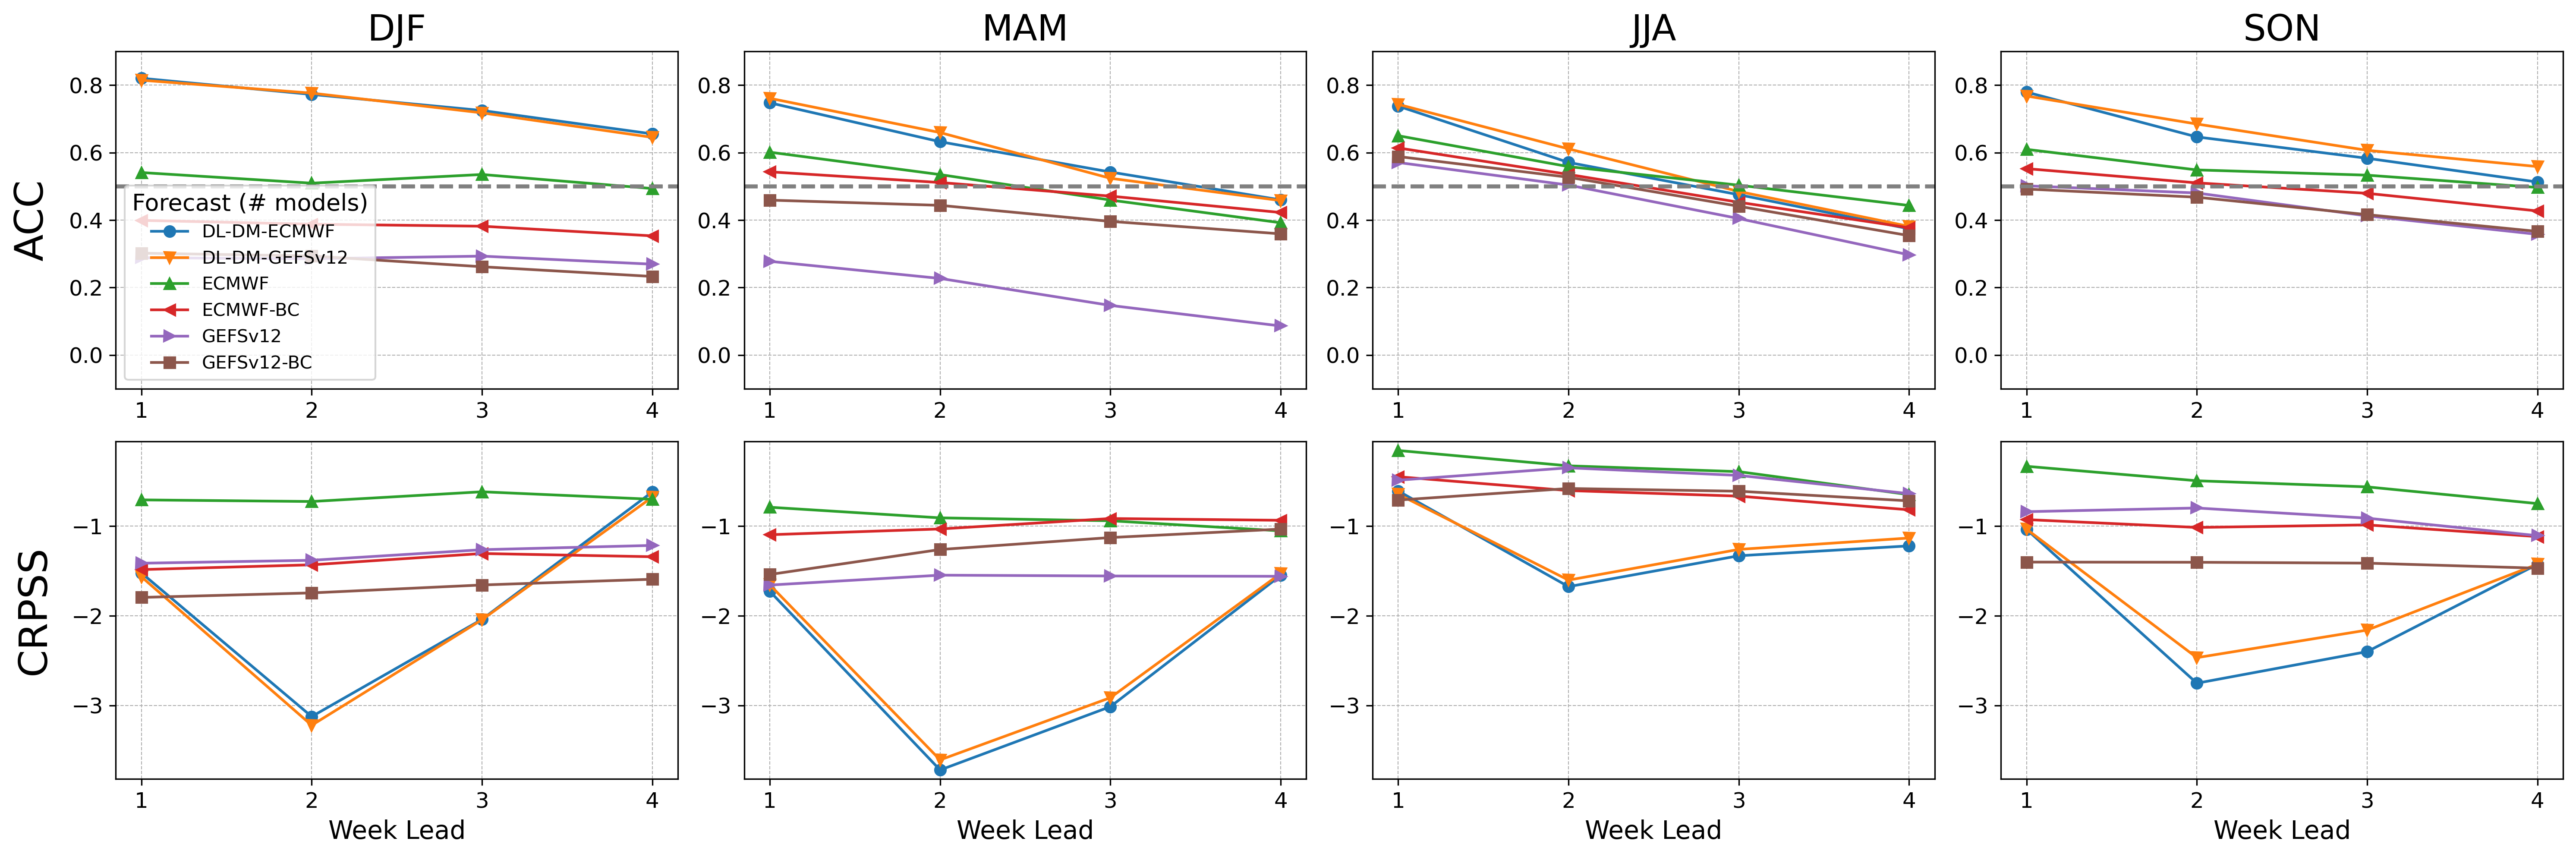

0

In [16]:


plot_ACC_CRPS_LinePlot(df_acc_full, df_crps_full, df_acc_djf, df_crps_djf, 
                       df_acc_mam, df_crps_mam, df_acc_jja, df_crps_jja, df_acc_son, df_crps_son,obs_source)


## Now plot with the improvement data in them

In [17]:
# Filtered dictionary: only keep keys that contain 'GEFsv12'
gefs_dict = {k: v for k, v in lead_improvment_plots.items() if 'GEFSv12' in k}
ecmwf_dict = {k: v for k, v in lead_improvment_plots.items() if 'ECMWF' in k}

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.cm import get_cmap

def plot_combined_ACC_CRPS_map_grid(df_acc_list, df_crps_list, forecast_dict, forecast_name, variable_name, cmap,obs_source):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    leads = [1, 2, 3, 4]
    marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
    palette = plt.get_cmap('tab10')
    
    fig, axs = plt.subplots(6, 4, figsize=(22, 20), dpi=300,)  # We'll override projection for maps later
    acc_max, acc_min = find_global_max_min(df_acc_list, 'ACC')
    crpss_max, crpss_min = find_global_max_min(df_crps_list, 'CRPSS')
    
    #manually change the max acc to 1 and add a small increment to the bottom
    acc_max = 0.9
    acc_min =-0.1
    
    crpss_min = crpss_min-0.1
    crpss_max = crpss_max+0.1

    # ✅ Inject Cartopy projection only in bottom 4 rows
    for row in range(2, 6):
        for col in range(4):
            axs[row, col].remove()
            axs[row, col] = fig.add_subplot(6, 4, row * 4 + col + 1, projection=ccrs.PlateCarree())
    
    # ------------------ Line Plots (Top 2 Rows) ------------------
    for row_idx, (df_list, metric) in enumerate(zip([df_acc_list, df_crps_list], ['ACC', 'CRPSS'])):
        for col_idx, df in enumerate(df_list):
            ax = axs[row_idx, col_idx]
            grouped = df.groupby('Forecast')
    
            for i, (name, group) in enumerate(grouped):
                color = palette(i)
                marker = marker_style[i % len(marker_style)]
                ax.plot(group['Week'], group[metric], label=name, color=color,
                        marker=marker, linestyle='-', markersize=6)
    
            ax.set_xlim(0.5, 4.5)
            ax.set_xticks([1, 2, 3, 4])
            ax.set_xticklabels(['1', '2', '3', '4'])
            ax.xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4]))
    
            ax.grid(True, linestyle='--', linewidth=0.5)
            ax.tick_params(labelsize=10)
            ax.set_ylim(acc_min if row_idx == 0 else crpss_min, acc_max if row_idx == 0 else crpss_max)
    
            if row_idx == 0:
                ax.axhline(0.5, linestyle='--', color='gray', linewidth=1.5)
                ax.set_title(seasons[col_idx], fontsize=20)
                # ax.set_title(seasons[col_idx], fontsize=20, fontweight='bold')
            if row_idx == 1:
                ax.set_xlabel('Lead Week', fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(metric, fontsize=14)
    
            if row_idx == 0 and col_idx == 0:
                ax.legend(title='Forecast', fontsize=9, title_fontsize=10)
    
    # ------------------ Compute global color scale for maps ------------------
    vmin_map = np.inf
    vmax_map = -np.inf
    for key in forecast_dict:
        if variable_name in forecast_dict[key].data_vars:
            data = forecast_dict[key][variable_name].values
            vmin_map = min(vmin_map, np.nanmin(data))
            vmax_map = max(vmax_map, np.nanmax(data))
    
    vmin_map = np.floor(vmin_map * 10) / 10
    vmax_map = np.ceil(vmax_map * 10) / 10
    cmap = get_cmap(cmap)
    norm = TwoSlopeNorm(vmin=vmin_map, vcenter=0, vmax=vmax_map)
    levels = np.arange(vmin_map, vmax_map , 0.2)
    
    
    # ------------------ Map Plots (Bottom 4 Rows) ------------------
    for row_idx, lead in enumerate(leads, start=2):
        for col_idx, season in enumerate(seasons):
            key = f'DL-DM_{forecast_name}_lead{lead}_season{season}'
            ax = axs[row_idx, col_idx]
            ax.set_aspect('auto')
    
            if key not in forecast_dict or variable_name not in forecast_dict[key].data_vars:
                ax.set_title(f'{key}\n(No data)', fontsize=10)
                ax.coastlines()
                continue
    
            ds = forecast_dict[key]
            data = ds[variable_name]
            lon = ds.lon.values
            lat = ds.lat.values
            mesh_lon, mesh_lat = np.meshgrid(lon, lat)
    
            im = ax.contourf(mesh_lon, mesh_lat, data.values,
                             levels=levels,
                             transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, extend='both')
    
    
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_title(f'Season: {season}, Week: {lead}', fontsize=14)
            # ax.set_title(f'Season: {season}, Week: {lead}', fontsize=12, fontweight='bold')

    
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
            gl.top_labels = gl.right_labels = False
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlabel_style = {'size': 8}
            gl.ylabel_style = {'size': 8}
    
    
    plt.tight_layout(rect=[0, 0, 0.93, 1])  # Adjust for suptitle spacing
    # Update ScalarMappable (same as before)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    # Colorbar axis
    cbar_ax = fig.add_axes([0.945, 0.12, 0.015, 0.50])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='both',
                        boundaries=levels, ticks=levels)
    # 0.92, 0.08, 0.015, 0.40
    # Labels and appearance
    cbar.set_label(f'ACC Improvement diff(EX29-{forecast_name}[BC])', fontsize=14, rotation=90, labelpad=15)
    cbar.ax.tick_params(labelsize=14, pad=2)

    row_labels = ['A', 'B', 'C', 'D', 'E', 'F']
    # row_labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']
    for row_idx, label in enumerate(row_labels):
        axs[row_idx, 0].text(
            -0.15, 1.05,  # ← coordinates (x, y) relative to that subplot
            label, 
            transform=axs[row_idx, 0].transAxes,  # ← place text in subplot's coordinate system
            fontsize=20, fontweight='bold', va='top', ha='right'
        )

    
    plt.savefig(f'Outputs/ACC_CRPS_line_plots/{region_name}/Combined_6x4_ACC_CRPS_{forecast_name}_{obs_source}_Map.png', dpi=300)
    plt.show()

/glade/derecho/scratch/klesinger/tmp/ipykernel_30063/2446399421.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


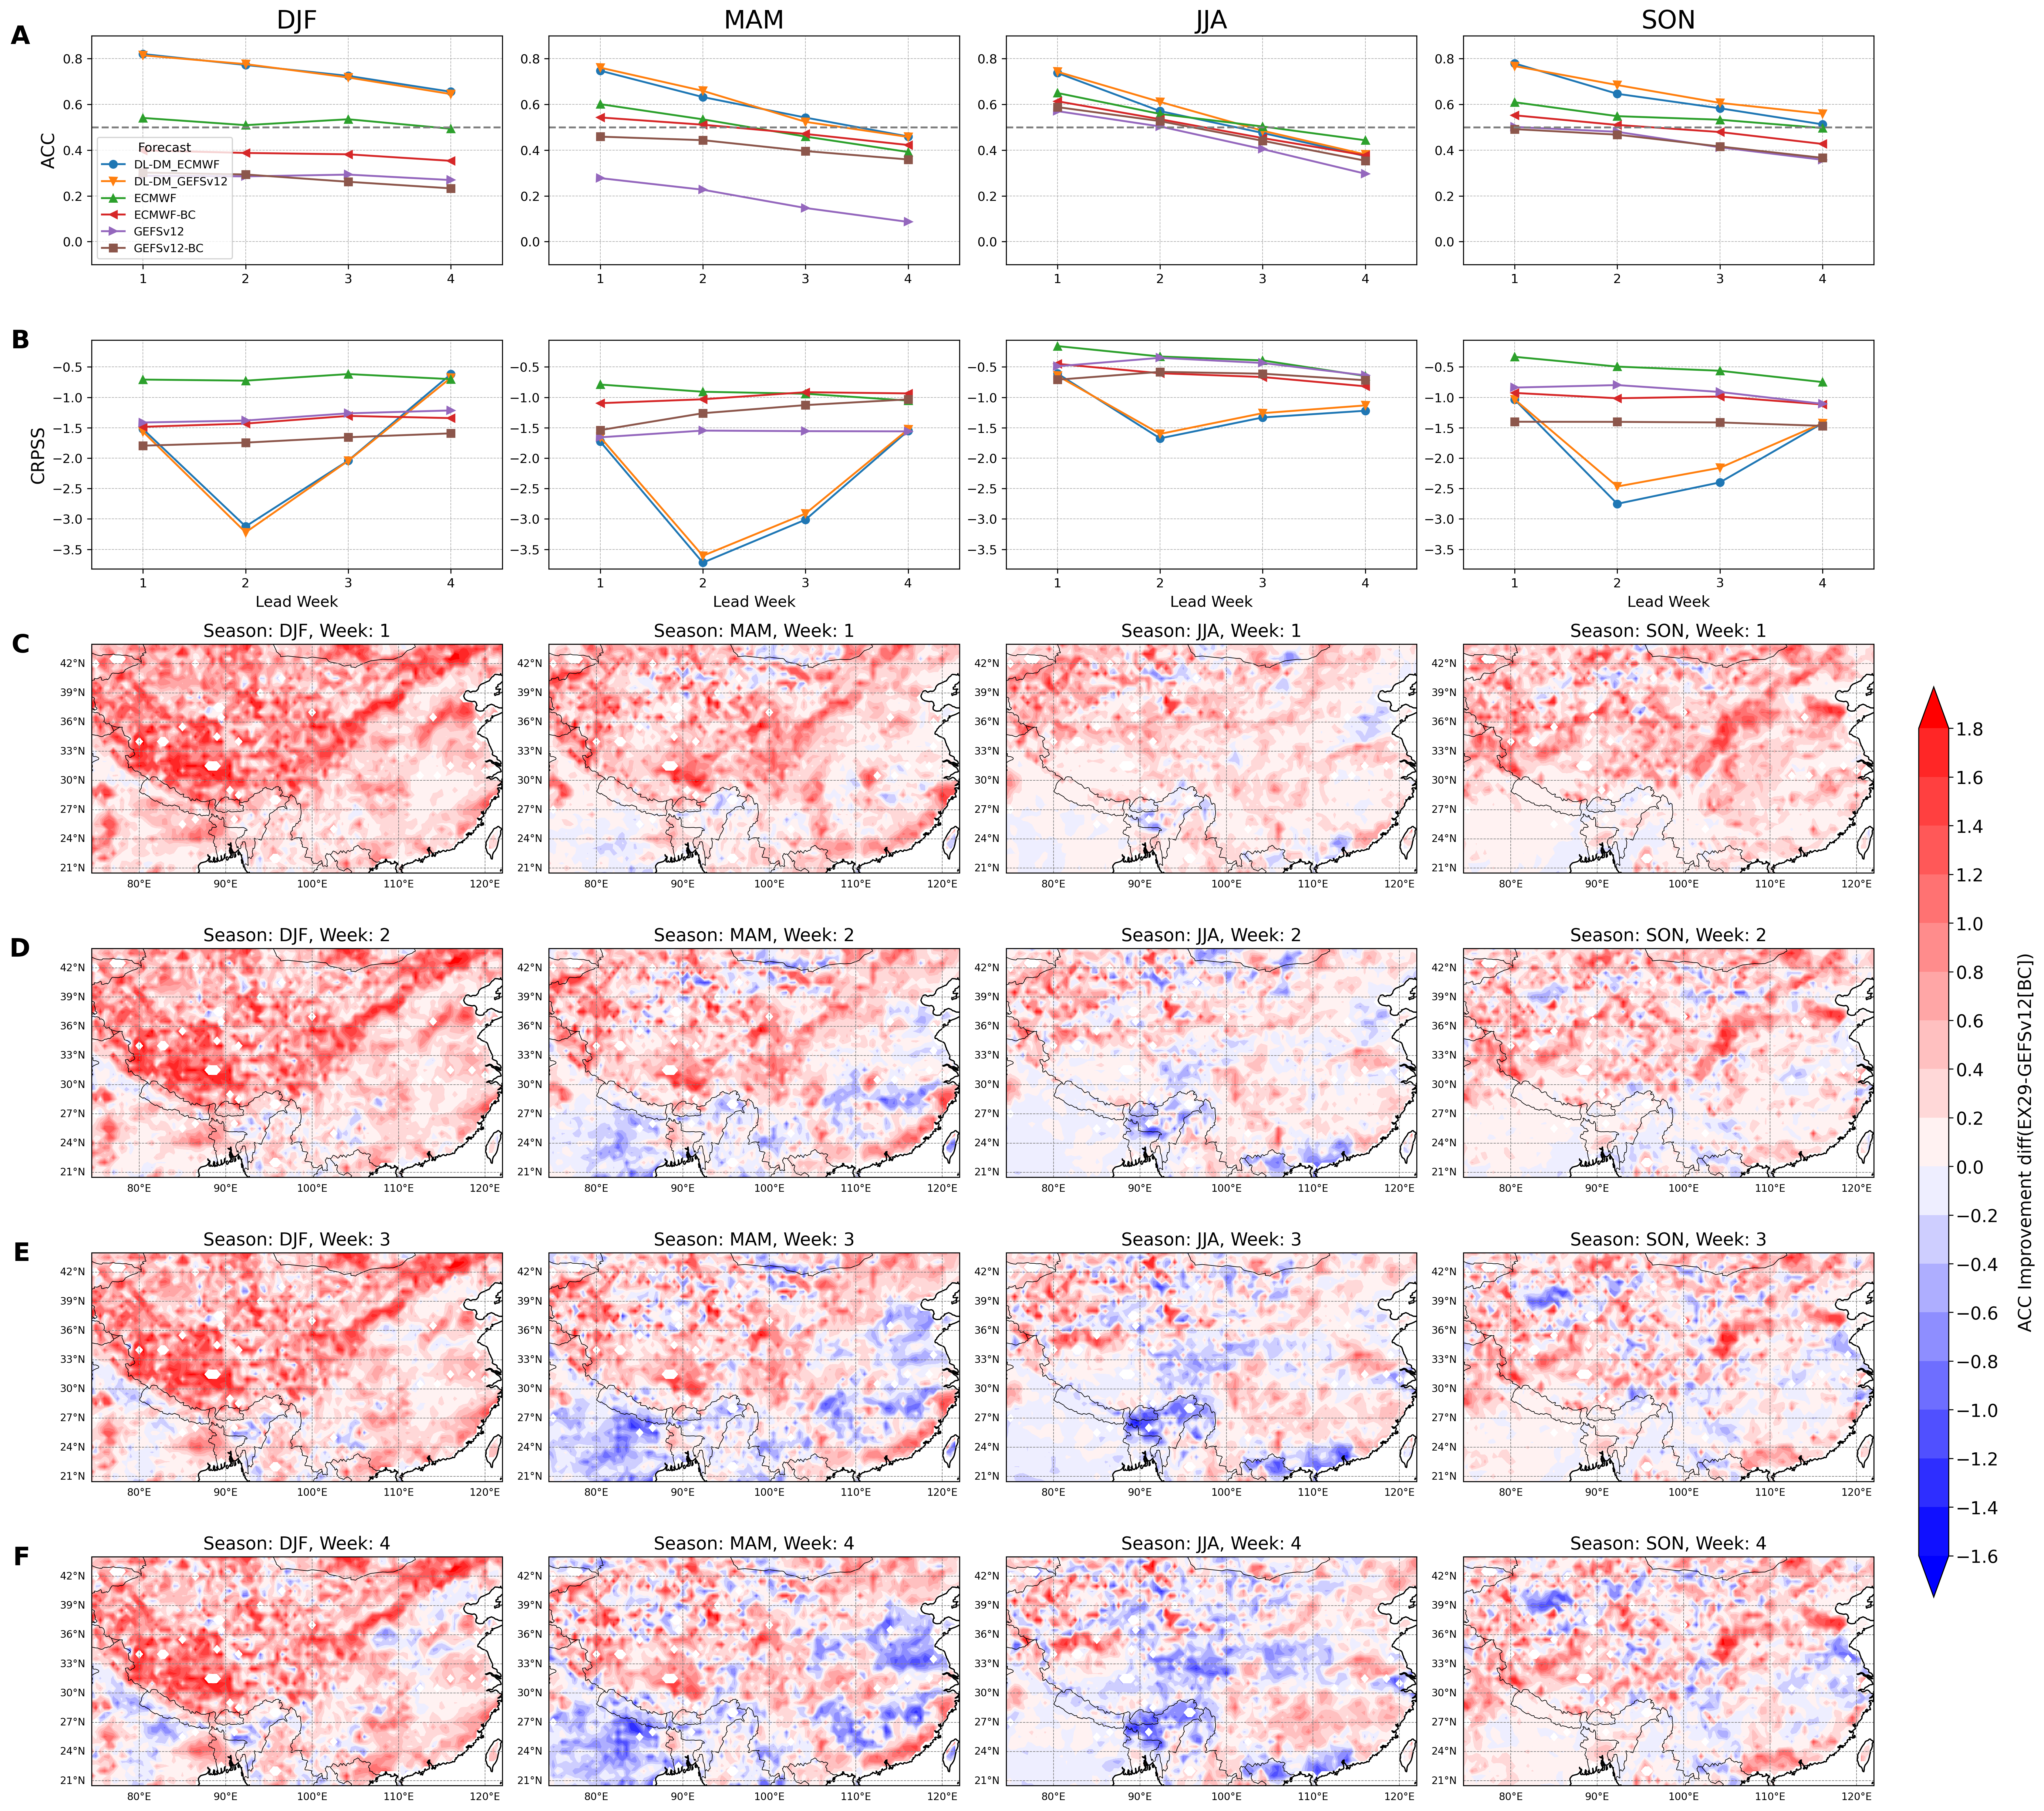

In [19]:
plot_combined_ACC_CRPS_map_grid(
    df_acc_list=[df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son],
    df_crps_list=[df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son],
    forecast_dict=gefs_dict,
    forecast_name='GEFSv12',
    variable_name='acc',
    cmap='bwr',
    obs_source=obs_source
)



In [20]:
# plot_combined_ACC_CRPS_map_grid(
#     df_acc_list=[df_acc_djf, df_acc_mam, df_acc_jja, df_acc_son],
#     df_crps_list=[df_crps_djf, df_crps_mam, df_crps_jja, df_crps_son],
#     forecast_dict=ecmwf_dict,
#     forecast_name='ECMWF',
#     variable_name='acc',
#     cmap='bwr',
# )